In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
from pathlib import Path
import fitz

from mozilla_sec_eia.utils.pdf import extract_pdf_data_from_page
from mozilla_sec_eia.utils.pdf import render_page

In [5]:
filepath = Path("../sec10k_filings/pdfs/40545-2004q1-40545-0000040545-04-000013.pdf")
assert filepath.exists()

In [6]:
doc = fitz.Document(str(filepath))
doc.is_pdf

True

Multi page PDFs show up as separate indices in doc.

In [11]:
len(doc)

2

In [15]:
pg = doc[1]
extracted = extract_pdf_data_from_page(pg)
extracted.keys()

dict_keys(['pdf_text', 'image', 'page'])

In [16]:
txt = extracted['pdf_text']
img_info = extracted['image']
pg_meta = extracted['page']
txt.shape, img_info.shape, pg_meta.shape

((198, 9), (0, 0), (1, 9))

In [12]:
pg_meta

,rotation_degrees,origin_x_pdf_coord,origin_y_pdf_coord,width_pdf_coord,height_pdf_coord,has_images,has_text,page_num,image_area_frac
0,0,0.0,0.0,595.275574,841.889771,False,True,0,0.0


In [17]:
pg.rect.width

595.2755737304688

In [18]:
pg.rect.height

841.8897705078125

In [20]:
pg.rect

Rect(0.0, 0.0, 595.2755737304688, 841.8897705078125)

Try combining both pages into a separate PDF with one longer page.

In [23]:
from fitz import Rect

In [91]:
combined_width = 0
combined_height = 0
rects = []
crop_boxes = []
for page in doc:
    pg_width = page.rect.width
    combined_width = max(combined_width, pg_width)
    # instead of using page height directly, use the height of the last word + a buffer
    full_pg_height = page.rect.height
    extracted = extract_pdf_data_from_page(page)
    pg_txt_height = extracted['pdf_text'].bottom_right_y_pdf.max() + (full_pg_height/100)
    # Translate this page down by the height of the previous page
    rects.append(Rect(0, combined_height, pg_width, combined_height + pg_txt_height))
    page.set_cropbox(Rect(0, 0, pg_width, pg_txt_height))
    combined_height += pg_txt_height

output_pdf = fitz.open()
combined_page = output_pdf.new_page(width=combined_width, height=combined_height)

for i in range(len(doc)):
    combined_page.show_pdf_page(rects[i], doc, i)

In [92]:
extracted = extract_pdf_data_from_page(combined_page)
extracted.keys()

dict_keys(['pdf_text', 'image', 'page'])

In [93]:
txt = extracted['pdf_text']
img_info = extracted['image']
pg_meta = extracted['page']
txt.shape, img_info.shape, pg_meta.shape

((440, 9), (0, 0), (1, 9))

In [94]:
txt

,top_left_x_pdf,top_left_y_pdf,bottom_right_x_pdf,bottom_right_y_pdf,text,block_num,line_num,word_num,page_num
0,539.356628,27.366436,558.110352,35.112061,Exhibit,0,0,0,0
1,559.674072,27.366436,565.929077,35.112061,21,0,0,1,0
2,29.346460,43.428936,69.351463,51.174561,SUBSIDIARIES,1,0,0,0
3,70.915215,43.428936,78.728340,51.174561,OF,1,0,1,0
4,80.292091,43.428936,116.854591,51.174561,REGISTRANT,1,0,2,0
...,...,...,...,...,...,...,...,...,...
435,325.092224,987.543518,346.039734,995.272278,included,79,0,19,0
436,347.603485,987.543518,351.979736,995.272278,in,79,0,20,0
437,353.543488,987.543518,368.865997,995.272278,above,79,0,21,0
438,370.429749,987.543518,402.947906,995.272278,percentages.,79,0,22,0


In [95]:
full_pg_img = render_page(combined_page)

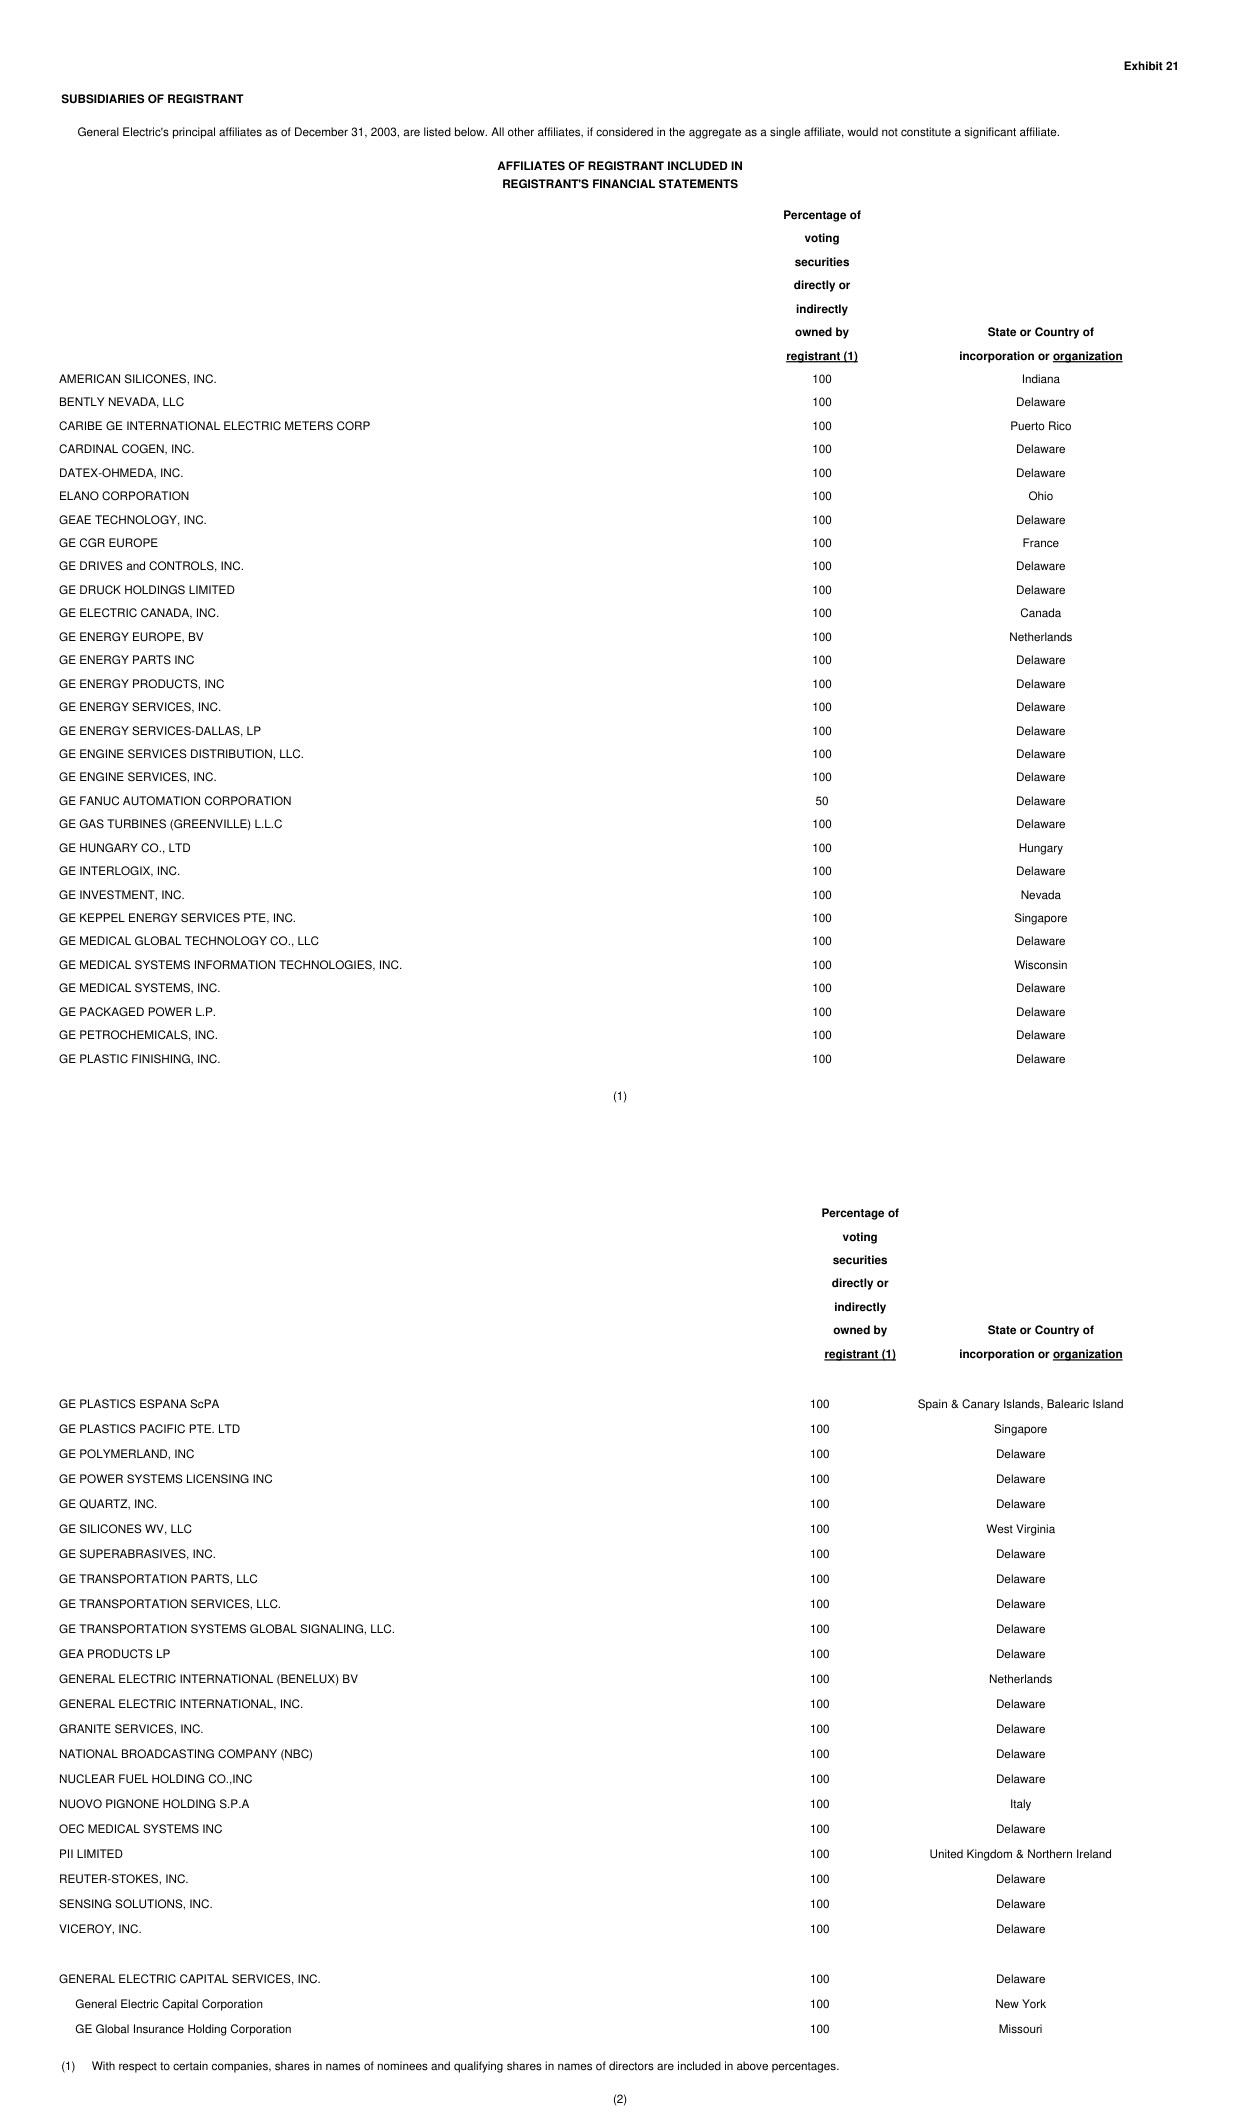

In [96]:
full_pg_img